# Part 1

In [ ]:
%pip install numpy==1.21.2 scipy==1.7.0 scikit-learn==1.0 matplotlib==3.4.3 pandas==1.3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Pytorch model

In [ ]:
%pip install torch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.4.3
Uninstalling matplotlib-3.4.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.4.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

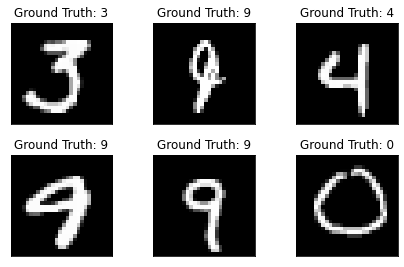

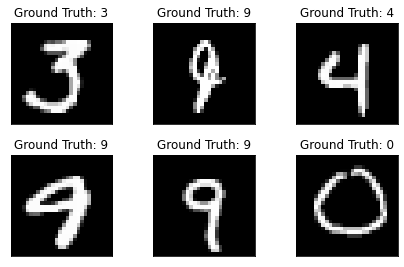

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140686
Train Epoch: 1 [12160/6

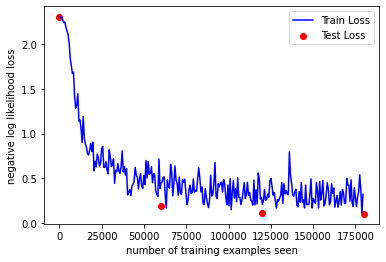

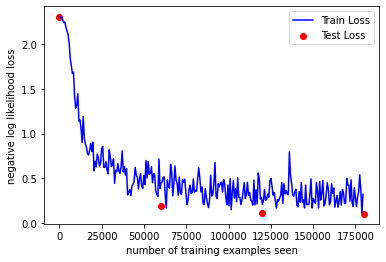

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [ ]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


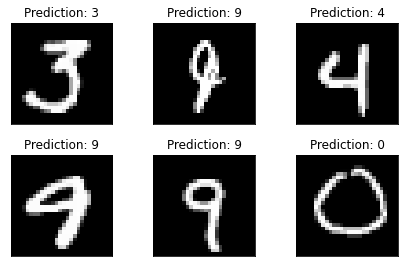

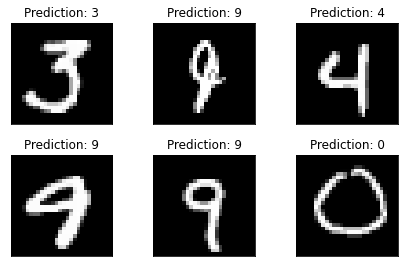

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## 

# Part 2

In [ ]:
import os
import scipy.io
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage.transform import resize
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications.densenet import DenseNet201

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!tar -xzf 102flowers.tgz;

--2022-07-07 14:27:07--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  21.8MB/s    in 16s     

2022-07-07 14:27:23 (20.8 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]

--2022-07-07 14:27:24--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2022-07-07 14:27:24 (98.7 MB/s) - ‘imagelabels.mat’ saved 

In [ ]:
def create_directory(dir_name):
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)

In [ ]:
def populate_directory(source_dir, target_base, file_type, filenames, labels):
  for filename in filenames:
    index = int((filename.split('.')[0]).split('_')[-1]) - 1
    target_dir = target_base + '/' + file_type + '/' + str(labels[index])
    create_directory(target_dir)
    shutil.copy(source_dir + '/' + filename, target_dir + '/' + filename)

In [ ]:
source_dir = 'jpg'
NUM_OF_OPERATIONS = 2

mat = scipy.io.loadmat('imagelabels.mat')
images_files = os.listdir(source_dir)
labels = mat['labels'][0].tolist()
print(images_files)
print(labels)

for i in range(NUM_OF_OPERATIONS):
  shutil.rmtree(f'data{i}', ignore_errors=True)
  os.mkdir(f'data{i}')
  os.mkdir(f'data{i}/train')
  os.mkdir(f'data{i}/valid')
  os.mkdir(f'data{i}/test')
  x_train,x_valid_test = train_test_split(images_files, test_size = 0.5)
  x_valid, x_test = train_test_split(x_valid_test ,test_size = 0.5)
  populate_directory(source_dir, f'data{i}', 'train', x_train, labels)
  populate_directory(source_dir, f'data{i}', 'valid', x_valid, labels)
  populate_directory(source_dir, f'data{i}', 'test', x_test, labels)

['image_03130.jpg', 'image_04922.jpg', 'image_06368.jpg', 'image_02220.jpg', 'image_00179.jpg', 'image_07776.jpg', 'image_05296.jpg', 'image_04548.jpg', 'image_03901.jpg', 'image_01457.jpg', 'image_03191.jpg', 'image_05354.jpg', 'image_04479.jpg', 'image_04270.jpg', 'image_03539.jpg', 'image_00005.jpg', 'image_03601.jpg', 'image_04651.jpg', 'image_02271.jpg', 'image_04325.jpg', 'image_02593.jpg', 'image_01109.jpg', 'image_00221.jpg', 'image_07954.jpg', 'image_04033.jpg', 'image_05516.jpg', 'image_00926.jpg', 'image_03407.jpg', 'image_00773.jpg', 'image_05047.jpg', 'image_01814.jpg', 'image_05634.jpg', 'image_02537.jpg', 'image_07673.jpg', 'image_05488.jpg', 'image_08179.jpg', 'image_02310.jpg', 'image_05696.jpg', 'image_06794.jpg', 'image_00578.jpg', 'image_01444.jpg', 'image_01095.jpg', 'image_02290.jpg', 'image_01754.jpg', 'image_03715.jpg', 'image_07916.jpg', 'image_04834.jpg', 'image_04213.jpg', 'image_01824.jpg', 'image_00904.jpg', 'image_03811.jpg', 'image_04182.jpg', 'image_0685

In [ ]:
batch_size = 32
num_classes = 102
image_width = 256
image_height = 256

vgg16_data0_accuracy = []
vgg16_data0_loss = []
vgg16_data1_accuracy = []
vgg16_data1_loss = []


densenet_data0_accuracy = []
densenet_data0_loss = []
densenet_data1_accuracy = []
densenet_data1_loss = []


img_data_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_data_generator = ImageDataGenerator( rescale = 1./255. )

In [ ]:
def plot_accuracy_loss(history, test_accuracy, test_loss):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    plt.figure()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
    axes[0].plot(epochs, acc, label='Training acc')
    axes[0].plot(epochs, val_acc, label='Validation acc')
    axes[0].plot(epochs, test_accuracy, label='Test acc')
    axes[0].legend()

    axes[1].plot(epochs, loss, label='Training loss')
    axes[1].plot(epochs, val_loss, label='Validation loss')
    axes[1].plot(epochs, test_loss, label='Test loss')
    axes[1].legend()

    plt.show()

In [ ]:
def build_model(base_model, num_classes=102):
    tf.keras.backend.clear_session()

    for layer in base_model.layers:
        layer.trainable=False

    model = tf.keras.models.Sequential([base_model,
                                        tf.keras.layers.GlobalAveragePooling2D(),
                                        Flatten(),
                                        Dense(512,activation="relu"),
                                        Dense(num_classes, activation='softmax')
                                ])    

    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['acc'])
    return model

In [ ]:
from tensorflow.keras.callbacks import Callback

class TestCallback(Callback):
    def __init__(self, test_data_generator, accuracy, loss):
        self.test_data_generator = test_data_generator
        self.accuracy = accuracy
        self.loss = loss

    def on_epoch_end(self, epoch, logs={}):
        print(f'Testing epoch #{epoch+1}')
        loss, accuracy = self.model.evaluate(self.test_data_generator, verbose=1)
        self.loss.append(loss)
        self.accuracy.append(accuracy)

In [ ]:
def train_model(base_folder, base_model, data_generator, test_data_generator, accuracy, loss):
    train_data = data_generator.flow_from_directory(f'{base_folder}/train',
                                                      target_size=(256, 256),
                                                      class_mode='categorical',
                                                      batch_size=32,
                                                      shuffle=True)
    print(train_data.class_indices)

    valid_data = data_generator.flow_from_directory(f'{base_folder}/valid',
                                                      target_size=(256, 256),
                                                      class_mode='categorical',
                                                      batch_size=32,
                                                      shuffle=True)
    
    predict_generator =  test_data_generator.flow_from_directory(f'{base_folder}/test',
                                                      batch_size=128, 
                                                      class_mode='categorical',
                                                      shuffle=False,
                                                      target_size=(256, 256))
    
    model = build_model(base_model)
    history = model.fit(train_data, validation_data=valid_data, epochs=25, steps_per_epoch=40, callbacks=[TestCallback(predict_generator, accuracy, loss)])
    return history
    

In [ ]:
vgg16_model = VGG16(input_shape=(image_height, image_width,3), include_top=False, weights="imagenet")

Found 4094 images belonging to 102 classes.
{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '

<Figure size 432x288 with 0 Axes>

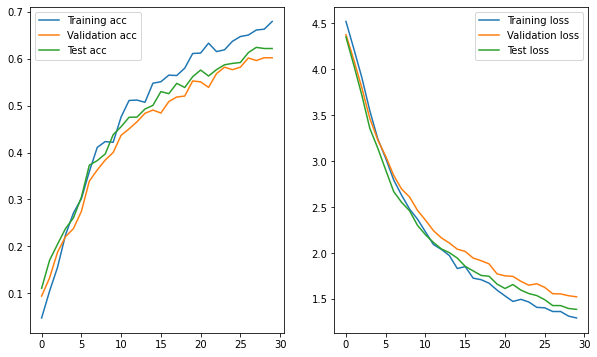

In [ ]:
vgg16_data0_accuracy = []
vgg16_data0_loss = []

vgg16_data0_history = train_model('data0',vgg16_model, img_data_generator, test_data_generator, vgg16_data0_accuracy, vgg16_data0_loss)
plot_accuracy_loss(vgg16_data0_history, vgg16_data0_accuracy, vgg16_data0_loss)

Found 4094 images belonging to 102 classes.
{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '

<Figure size 432x288 with 0 Axes>

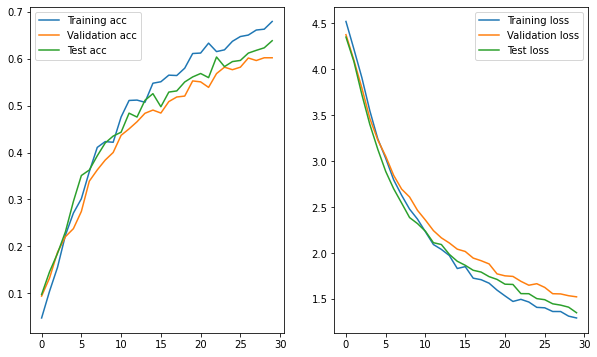

In [ ]:
vgg16_data1_accuracy = []
vgg16_data1_loss = []

vgg16_data1_history = train_model('data1',vgg16_model, img_data_generator, test_data_generator, vgg16_data1_accuracy, vgg16_data1_loss)
plot_accuracy_loss(vgg16_data0_history, vgg16_data1_accuracy, vgg16_data1_loss)

In [ ]:
densenet_model = DenseNet201(input_shape=(image_height, image_width, 3), weights="imagenet", include_top=False)

Found 4094 images belonging to 102 classes.
{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '

<Figure size 432x288 with 0 Axes>

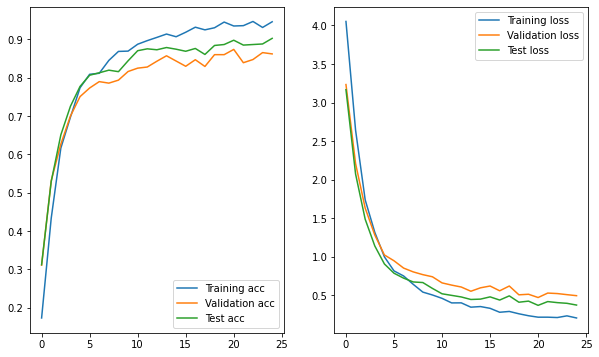

In [ ]:
densenet_data0_accuracy = []
densenet_data0_loss = []

densenet_data0_history = train_model('data0',densenet_model, img_data_generator, test_data_generator, densenet_data0_accuracy, densenet_data0_loss)
plot_accuracy_loss(densenet_data0_history, densenet_data0_accuracy, densenet_data0_loss)

Found 4094 images belonging to 102 classes.
{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '

<Figure size 432x288 with 0 Axes>

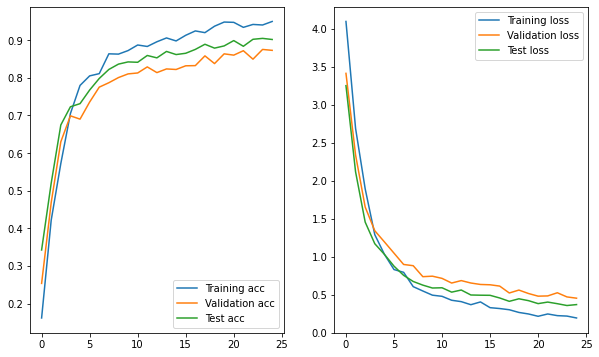

In [ ]:
densenet_data1_accuracy = []
densenet_data1_loss = []

densenet_data1_history = train_model('data0', densenet_model, img_data_generator, test_data_generator, densenet_data1_accuracy, densenet_data1_loss)
plot_accuracy_loss(densenet_data1_history, densenet_data1_accuracy, densenet_data1_loss)